In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys

from tqdm import tqdm
import pickle
import h5py

import numpy as np
from astropy.cosmology import Planck18
from astropy import units as u
from astropy import constants as const

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps as cms
mpl.rc_file('../matplotlibrc')

In [2]:
wdir = os.environ['DM21CM_DIR']
sys.path.append(wdir)
#sys.path.append(wdir + "/build_tf")
sys.path.append(os.environ['DH_DIR'])
data_dir = '/n/holyscratch01/iaifi_lab/yitians/dm21cm/DM21cm/data/tf/zf01/data'

## Attenuation

In [4]:
from dm21cm.dh_wrappers import TransferFunctionWrapper
from dm21cm.utils import load_h5_dict
from darkhistory.spec.spectrum import Spectrum

In [5]:
data_dir = '/n/holyscratch01/iaifi_lab/yitians/dm21cm/DM21cm/data/tf/zf01/data'

In [6]:
abscs = load_h5_dict(f"{data_dir}/abscissas.h5")

In [7]:
tf_wrapper = TransferFunctionWrapper(
    box_dim = 1,
    abscs = abscs,
    prefix = data_dir,
    enable_elec = False,
    on_device = False,
)

In [9]:
atten_arr = tf_wrapper.attenuation_arr(rs=6, x=0.001)

In [16]:
import dm21cm.physics as phys

In [17]:
phys.conformal_dt_between_z?

Signature: phys.conformal_dt_between_z(z_high, z_low)
Docstring:
Calculate conformal delta t [conformal s] between z_high and z_low.

Args:
    z_high (float): Higher redshift.
    z_low (float): Lower redshift.

Returns:
    float: Delta conformal t [conformal s].
File:      ~/dm21cm/DM21cm/dm21cm/physics.py
Type:      function

In [18]:
(phys.conformal_dt_between_z(5, 5.05) * u.s * const.c).to(u.Mpc)

<Quantity -26.77083065 Mpc>

Text(0.5, 0, 'Photon Energy (eV)')

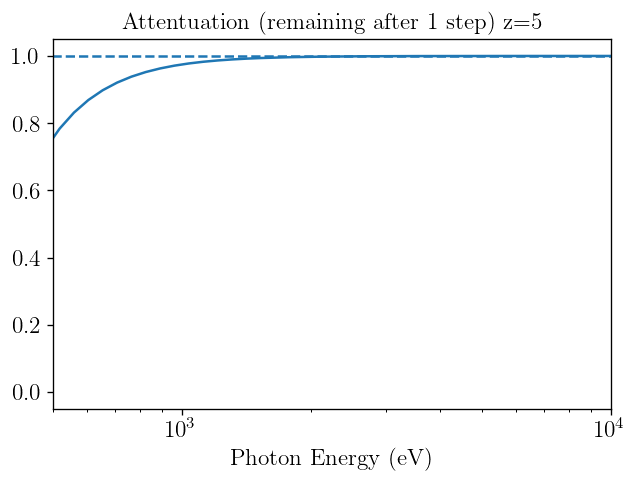

In [14]:
plt.plot(abscs['photE'], atten_arr)
plt.plot(abscs['photE'], np.ones_like(atten_arr), color='C0', ls='--')
plt.xscale('log')
plt.xlim(500, 1e4)
plt.title('Attentuation (remaining after 1 step) z=5')
plt.xlabel('Photon Energy (eV)')

## Smoothing at z=10

In [42]:
r = np.load(wdir + '/outputs/dm21cm/ct_128_256Mpc_nopop2_records.npy', allow_pickle=True).item()

In [45]:
r['z'][143]

9.90018019138455

In [46]:
delta = r['delta_box'][143]

In [51]:
from dm21cm.data_cacher import Cacher
from astropy.cosmology import Planck18
from jax.numpy import fft

In [49]:
c = Cacher('tmp.h5', Planck18, 128, 2, xraycheck=True)

In [58]:
from dm21cm.interpolators_jax import SFRDInterpolator
from scipy import interpolate

hmf_tables = load_h5_dict(f"{data_dir}/hmf_tables.h5")
z_range = hmf_tables['z_range']
delta_range = hmf_tables['delta_range']
r_range = hmf_tables['r_range']
cond_sfrd_table = hmf_tables['cond_sfrd_table']
st_sfrd_table = hmf_tables['st_sfrd_table']

Cond_SFRD_Interpolator = SFRDInterpolator(z_range, delta_range, r_range, cond_sfrd_table) # jax good
ST_SFRD_Interpolator = interpolate.interp1d(z_range, st_sfrd_table)

In [96]:
import dm21cm.physics as phys
def get_smoothing_radii(z_receiver, z_donor):
    return np.abs(phys.conformal_dt_between_z(z_receiver, z_donor)) * phys.c / phys.Mpc

def get_sfrd_R(z, delta, z_donor):
    R = get_smoothing_radii(z, z_donor)
    delta_smooth, _ = c.smooth_box(fft.rfftn(delta), 0, R)
    delta_smooth = np.array(delta_smooth)
    delta_smooth = np.clip(delta_smooth, -1+1e-6, 1.5-1e-6)
    e = Cond_SFRD_Interpolator(z, delta_smooth, R)
    return e * (ST_SFRD_Interpolator(z_donor) / np.mean(e)), R

In [98]:
np.sum(delta > 1.5)

225

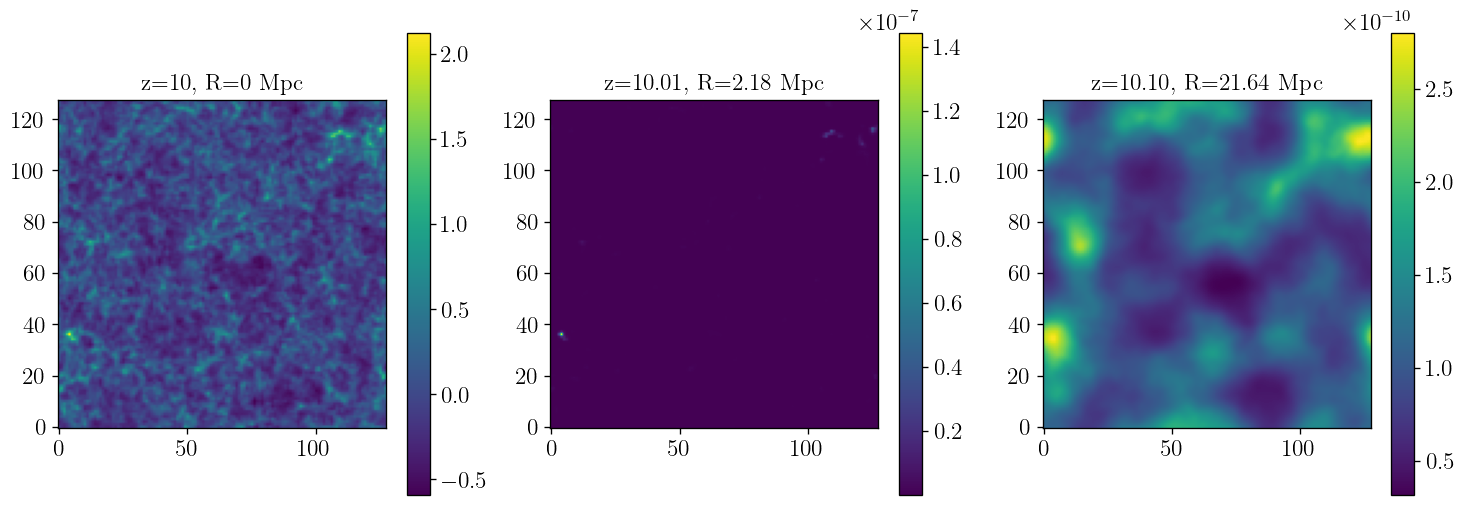

In [97]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

ax = axs[0]
im = ax.imshow(delta[0], origin='lower')
ax.set(title=f'z=10, R=0 Mpc')
fig.colorbar(im, ax=ax)

for i, z in enumerate([10.01, 10.1]):
    d, R = get_sfrd_R(10, delta, z)
    ax = axs[i+1]
    im = ax.imshow(d[0], origin='lower')
    ax.set(title=f'z={z:.2f}, R={R:.2f} Mpc')
    fig.colorbar(im, ax=ax)

## R smooth for z=20

In [3]:
from dm21cm.evolve import get_z_edges

/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/_cfg.py:58: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn(
/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/_cfg.py:42: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


In [8]:
z_edges = get_z_edges(45, 5, 1.001)
z_edges[1000]

15.932600966457208

In [6]:
import dm21cm.physics as phys

In [7]:
def get_smoothing_radii(z_receiver, z1, z2):
    """Evaluates the shell radii [cfMpc] for a receiver at `z_receiver` for emission between redshifts `z1` and `z2`."""
    R1 = np.abs(phys.conformal_dt_between_z(z_receiver, z1)) * phys.c / phys.Mpc
    R2 = np.abs(phys.conformal_dt_between_z(z_receiver, z2)) * phys.c / phys.Mpc
    return R1, R2

In [9]:
print("i z R1 R2")
i = 1000
while True:
    i -= 1
    R1, R2 = get_smoothing_radii(z_edges[1000], z_edges[1000], z_edges[i])
    print(i, z_edges[i], R1, R2)
    if R2 > 128:
        break
    if i == 0:
        break

i z R1 R2
999 15.949533567423664 0.0 1.9302722505983683
998 15.966483100991088 0.0 3.8595785640363607
997 15.983449584092078 0.0 5.787919416904959
996 16.000433033676167 0.0 7.715295285572381
995 16.017433466709843 0.0 9.641706646185037
994 16.03445090017655 0.0 11.567153974665663
993 16.051485351076725 0.0 13.491637746714666
992 16.0685368364278 0.0 15.415158437810684
991 16.085605373264226 0.0 17.337716523209117
990 16.102690978637487 0.0 19.259312477943034
989 16.119793669616122 0.0 21.1799467768238
988 16.136913463285737 0.0 23.09961989443991
987 16.15405037674902 0.0 25.01833230515758
986 16.171204427125765 0.0 26.936084483121274
985 16.18837563155289 0.0 28.852876902253414
984 16.205564007184442 0.0 30.768710036253758
983 16.222769571191623 0.0 32.683584358600235
982 16.239992340762814 0.0 34.597500342549615
981 16.257232333103577 0.0 36.510458461135855
980 16.274489565436678 0.0 38.422459187171214
979 16.291764055002112 0.0 40.333502993246526
978 16.30905581905711 0.0 42.2435903

In [ ]:
R1, R2 = self.get_smoothing_radii(z_receiver, z_donor, z_next_donor)

## dep dependence on delta

In [11]:
from dm21cm.dh_wrappers import DarkHistoryWrapper, TransferFunctionWrapper
from dm21cm.utils import load_h5_dict
from darkhistory.spec.spectrum import Spectrum

In [7]:
data_dir = '/n/holyscratch01/iaifi_lab/yitians/dm21cm/DM21cm/data/tf/zf01/data'

In [8]:
abscs = load_h5_dict(f"{data_dir}/abscissas.h5")

In [9]:
tf_wrapper = TransferFunctionWrapper(
    box_dim = 1,
    abscs = abscs,
    prefix = data_dir,
    enable_elec = False,
    on_device = False,
)

In [12]:
np.searchsorted(abscs['photE'], 500)

200

In [19]:
s = Spectrum(abscs['photE'], np.zeros((500,)), spec_type='N', rs=10)
s.N[200] = 1
print(s.toteng())
out = tf_wrapper.phot_dep_tf(rs=10, in_spec=s.N, nBs_s = np.array([9.99]), x_s=np.array([1e-4]))

518.7538452610509


In [16]:
np.sum(out[:5]) / s.toteng()

Array(0.4673794, dtype=float32)

In [20]:
np.sum(out[:5]) / s.toteng()

Array(1., dtype=float32)

In [21]:
d = load_h5_dict(f"{data_dir}/hmf_tables.h5")

[]

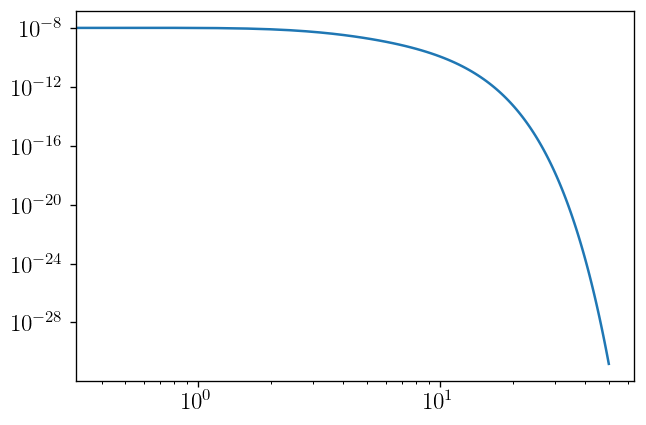

In [24]:
plt.plot(d['z_range'],d['st_sfrd_table'])
plt.loglog()

In [10]:
tf_wrapper.phot_dep_tf.__call__?

Signature:
tf_wrapper.phot_dep_tf.__call__(
    rs=None,
    in_spec=None,
    nBs_s=None,
    x_s=None,
    sum_result=False,
    sum_weight=None,
    sum_batch_size=2097152,
    out_of_bounds_action='error',
)
Docstring:
Batch interpolate in (nBs and) x directions.

First sum with in_spec (with caching), then interpolate to a rs point,
then perform the interpolation on [(nBs_s), x_s]. If sum_result is True,
sum over all interpolated value.

Parameters:
    rs : [1]
    in_spec : [N * ...]
    nBs_s : [1]
    x_s : [1]
    sum_result : if True, return average in the batch dimension.
    sum_weight : if None, just sum. otherwise dot.
    sum_batch_size : perform batch interpolation (and averaging) in batches of this size.
    out_of_bounds_action : {'error', 'clip'}

Return:
    interpolated box or average of interpolated box.
File:      ~/dm21cm/DM21cm/dm21cm/interpolators_jax.py
Type:      method

In [16]:
from scipy import interpolate

In [17]:
def debug_get_21totf_interp(fn):
    line_arr = []
    z_arr = []
    e_arr = []
    with open(fn, 'r') as f:
        for line in f:
            if "E_tot_ave = " in line:
                line_arr.append(line)
                tokens = line.split('E_tot_ave = ')
                e_arr.append(float(tokens[-1]))
                tokens = tokens[0].split('zp = ')
                z_arr.append(float(tokens[1]))

    # z_arr = np.array(z_arr)[1:]
    # e_arr = np.array(e_arr)[:-1]
    assert len(z_arr) == len(e_arr)
    return interpolate.interp1d(z_arr, e_arr, kind='linear', bounds_error=False, fill_value='extrapolate')

In [19]:
WDIR = os.environ['DM21CM_DIR']
interp = debug_get_21totf_interp(f"{WDIR}/outputs/stdout/xc_nopop2_noHe_nosp_noatten_esf.out")

In [20]:
interp(7.757164e+00)

array(0.00115426)

In [11]:
z_arr, e_arr = debug_get_21totf_interp("../scripts/xc_nopop2_noHe_nosp_noatten_esf.out")

[]

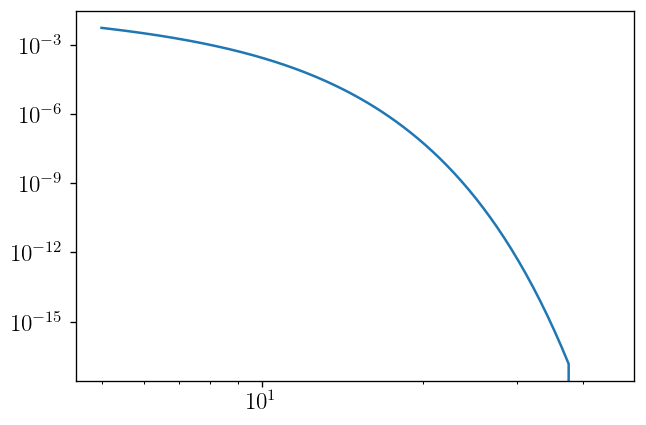

In [14]:
plt.plot(z_arr, e_arr)
plt.loglog()